# Расчет вертикального прогиба балки

Дифференциальное уравнение для вертикального прогиба имеет вид:

\begin{equation}
\frac{d^4y}{dx^4} = - \frac{2}{I} \frac{dI}{dx}\cdot \frac{d^3y}{dx^3} - \frac{1}{I} \frac{d^2I}{dx^2}\cdot \frac{d^2y}{dx^2} + \frac{\omega}{EI},
\end{equation}

где $x$ - горизонтальное расстояние вдоль балки, $y$ - вертикальный прогиб, $l$ - длина балки, $M$ - изгибающий момент, $E$ - модуль Юнга, $I$ - момент инерции, $P$ - нагрузка на балку.

Рассмотрим последнее слагаемое:

$\omega = -\frac{d^2M}{dx^2}$<br/>
$M(x) = -P \cdot (l - x)$

Так как $\frac{d^2M}{dx^2} = 0$ при $\forall x$, то и $\frac{\omega}{EI} = 0$ при $\forall x$.

Рассмотрим функцию $I(x)$ и ее производные:
\begin{equation}
I = 5(1 + 4e^{-\frac{6x}{l}})
\end{equation}

\begin{equation}
\frac{dI}{dx} = -\frac{120}{l}e^{-\frac{6x}{l}}
\end{equation}

\begin{equation}
\frac{d^2I}{dx^2} = \frac{720}{l}e^{-\frac{6x}{l}}
\end{equation}

Подставив все значения в исходное уравнение получим:

\begin{equation}
\frac{d^4y}{dx^4} = \frac{2}{5(1 + 4e^{-\frac{6x}{l}})} \cdot \frac{120}{l}e^{-\frac{6x}{l}} \cdot \frac{d^3y}{dx^3} - 
\frac{1}{5(1 + 4e^{-\frac{6x}{l}})} \cdot \frac{720}{l}e^{-\frac{6x}{l}} \cdot \frac{d^2y}{dx^2}
\end{equation}

Предварительно найдем значение длины балки: $l = 50\cdot x^*$, где $x^*$ - корень уравнения на промежутке $[1, 4]$:
\begin{equation}
\int_0^{20} \frac{e^{-0.9z}}{z+x}dz = 0.1957981\cdot x
\end{equation}

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate
from scipy.optimize import fsolve

In [2]:
def fun(x: int):
    def inner(z: int):
        return math.exp(-0.9 * z)/(z + x)
    return integrate.quad(inner, 0, 20)[0] - 0.1957981 * x;

In [3]:
x_star, = fsolve(fun, (4 - 1) / 2)
print('x* = {0}'.format(x_star))

l = 50 * x_star
print('Длина балки l = {0}'.format(l))

x* = 1.9996955172047453
Длина балки l = 99.98477586023726


Начальные условия:

$y(0) = y'(0) = 0$,<br/>
$y''(0) = \frac{Pl}{75}\cdot 10^{-7}$,<br/>
$y'''(0) = \frac{P \cdot 3.8}{75}\cdot 10^{-7}$

In [4]:
def get_y0(p: int):
    y0_1 = 0
    y0_2 = 0
    y0_3 = p * l / 75 * 10 ** (-7)
    y0_4 = p * 3.8 / 75 * 10 ** (-7)
    return np.array([y0_1, y0_2, y0_3, y0_4])

Значения нагрузки на балку будет менять в диапазоне $500 \div 1000$ с шагом $100$. При этом значение $P_0 = 750$

In [5]:
def get_p():
    return np.arange(500, 1000 + 1, 100)
p0 = 750

Перейдем к решению дифференциального уравнения. Для этого произведем следующшие замены:

$x_1(t) = y(t)$,<br/>
$x_2(t) = y'(t)$,<br/>
$x_3(t) = y''(t)$,<br/>
$x_4(t) = y'''(t)$.<br/>

С их помощью исходное дифференциальное уравнение сводится к системе дифференциальных уравнений первого порядка:

\begin{equation}
\begin{pmatrix}
    x'_1(t) \\
    x'_2(t) \\
    x'_3(t) \\
    x'_4(t) \\
\end{pmatrix} =
\begin{pmatrix}
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \\
    0 & 0 & - \frac{1}{I} \frac{d^2I}{dx^2} & - \frac{2}{I} \frac{dI}{dx} \\
\end{pmatrix}
\cdot
\begin{pmatrix}
    x_1(t) \\
    x_2(t) \\
    x_3(t) \\
    x_4(t) \\
\end{pmatrix}
\end{equation}

In [6]:
def evaluate(y: np.array, t: float):
    a = -1 / (5 * (1 + 4 * math.exp(-6 * t/l))) * (720 * math.exp(-6 * t/l)) / l
    b = 2 / (5 * (1 + 4 * math.exp(-6 * t/l))) * (120 * math.exp(-6 * t/l)) / l
    y4 = a * y[2] + b * y[3]
    return np.array([y[1], y[2], y[3], y4])

Будем решать дифференциальное уравнение в диапазоне $95 \div 105$ с шагом $0.01$ для заданных значений $P$.

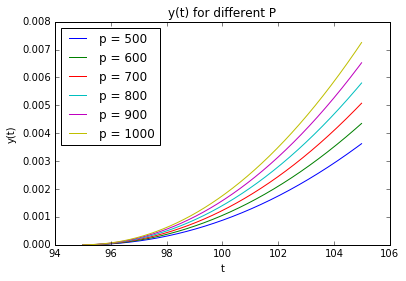

In [7]:
t0 = 95
tn = 105
th = 0.01
t = np.arange(t0, tn, th)
values = []

for p in get_p():
    y0 = get_y0(p)
    res = integrate.odeint(evaluate, y0, t)
    y = np.transpose(res)[0]
    values.append(y)

    plt.plot(t, y, label='p = {0}'.format(p))

plt.legend(loc='upper left')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('y(t) for different P')
plt.show()

In [8]:
p_interps = np.array([])
l_values = []

for i in range(len(values)):
    p_interp = interpolate.interp1d(t, values[i])
    p_interps = np.append(p_interps, p_interp)
    
    l_value = p_interp(l)
    l_values.append(l_value)
    
    print('P = {p}, f(l) = {value}'.format(p=get_p()[i], value=l_value))

P = 500, f(l) = 0.0008725763971333783
P = 600, f(l) = 0.0010470949652251179
P = 700, f(l) = 0.0012216129741276355
P = 800, f(l) = 0.0013961314783032636
P = 900, f(l) = 0.0015706504939714463
P = 1000, f(l) = 0.0017451698409788581


In [9]:
l_interp = interpolate.interp1d(get_p(), l_values, kind='cubic')
l_p0 = l_interp(p0)
print('P = {p}, f(l) = {value}'.format(p=p0, value=l_p0))

P = 750, f(l) = 0.0013088721478598997
